# Opt. Techniques with Text Data

In [1]:
# NLP Multi-Class Classification with DNN using Opt. Alg.

# Datasets
#  - AG News Classification Dataset : https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset & http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html

# Opt. Algorithms
    # - Stokastik Gradient Descent
    # - Stokastik Gradient Descent with Momentum
    # - Stokastik Adam

# AG News Dataset
    # - Class Index: Consists of 1-4 numbers which represents class of which 1-World, 2-Sports, 3-Business, 4-Sci/Tech
    # - Title: Contains Title of the Articles
    # - Description: Contains Description of the Articles
    # - Data Shape: Train: 120K & Test: 7600

### Import Libraries

In [2]:
import os
import warnings

from src.utils import get_project_config
from src.utils import missing_values
import pandas as pd
from dotenv import load_dotenv

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam

2024-11-18 22:47:57.167426: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 22:47:57.169327: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 22:47:57.202783: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 22:47:57.203507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 22:47:57.701842: W tensorflow/compiler/tf2t

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

warnings.filterwarnings('ignore')

#### Set Path and Constant Values

In [5]:
# Set Constants
ROOT_PATH = os.getcwd()
CFG_PATH = os.path.join(ROOT_PATH, 'cfg')
DATA_PATH = os.path.join(ROOT_PATH, 'data')

In [6]:
# import tensorflow as tf
# tf.config.list_physical_devices('GPU')

In [7]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

### Import Dataset

In [8]:
df_train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv.zip"), compression='zip')
df_train_data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."


In [9]:
df_test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv.zip"), compression='zip')
df_test_data.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
1,4,The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com),"SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket."
2,4,Ky. Company Wins Grant to Study Peptides (AP),"AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins."
3,4,Prediction Unit Helps Forecast Wildfires (AP),"AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar."
4,4,Calif. Aims to Limit Farm-Related Smog (AP),"AP - Southern California's smog-fighting agency went after emissions of the bovine variety Friday, adopting the nation's first rules to reduce air pollution from dairy cow manure."


In [10]:
df_train_data_orj = df_train_data.copy()
df_test_data_orj = df_test_data.copy()

### Columns Transformation

In [11]:
df_data_list = [df_train_data, df_test_data]
class_map = {1:'World', 2:'Sports', 3:'Business', 4:'Sci/Tech'}

for df in df_data_list:
    # print("DataFrame Name:", df)
    df.columns = df.columns.str.replace(' ', '', regex=False)
    df['ClassName'] = df['ClassIndex'].map(class_map)

In [12]:
df_train_data['Text'] = df_train_data['Title'] + ' ' + df_train_data['Description']
df_test_data['Text'] = df_test_data['Title'] + ' ' + df_test_data['Description']

In [13]:
df_train_data.head()

,ClassIndex,Title,Description,ClassName,Text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",Business,"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",Business,"Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,Business,Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",Business,"Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.",Business,"Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."


### Show Metadata, Shape, Statistics and Missing Table

In [14]:
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ClassIndex   120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
 3   ClassName    120000 non-null  object
 4   Text         120000 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.6+ MB


In [15]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ClassIndex   7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
 3   ClassName    7600 non-null   object
 4   Text         7600 non-null   object
dtypes: int64(1), object(4)
memory usage: 297.0+ KB


In [16]:
df_train_data.shape, df_test_data.shape

((120000, 5), (7600, 5))

In [17]:
df_train_data['ClassIndex'].value_counts()

ClassIndex
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

In [18]:
df_test_data['ClassIndex'].value_counts()

ClassIndex
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64

In [19]:
missing_values(df=df_train_data, threshold=0, asc_sorting=False)

,Count,Percent
Columns,,
ClassIndex,0,0.0
Title,0,0.0
Description,0,0.0
ClassName,0,0.0
Text,0,0.0


In [20]:
missing_values(df=df_test_data, threshold=0, asc_sorting=False)

,Count,Percent
Columns,,
ClassIndex,0,0.0
Title,0,0.0
Description,0,0.0
ClassName,0,0.0
Text,0,0.0


### Data Analysis

In [21]:
# Metin uzunluklarını hesapla
# Train Dataset
df_train_data["TitleLength"] = df_train_data["Title"].apply(len)
df_train_data["TitleWordCount"] = df_train_data['Title'].str.split().str.len()

df_train_data["DescriptionLength"] = df_train_data["Description"].apply(len)
df_train_data["DescriptionWordCount"] = df_train_data['Description'].str.split().str.len()

df_train_data["TextLength"] = df_train_data["Text"].apply(len)
df_train_data["TextWordCount"] = df_train_data['Text'].str.split().str.len()

# Test Dataset
df_test_data["TitleLength"] = df_test_data["Title"].apply(len)
df_test_data["TitleWordCount"] = df_test_data['Title'].str.split().str.len()

df_test_data["DescriptionLength"] = df_test_data["Description"].apply(len)
df_test_data["DescriptionWordCount"] = df_test_data['Description'].str.split().str.len()

df_test_data["TextLength"] = df_test_data["Text"].apply(len)
df_test_data["TextWordCount"] = df_test_data['Text'].str.split().str.len()

In [22]:
df_train_data.head(3)

,ClassIndex,Title,Description,ClassName,Text,TitleLength,TitleWordCount,DescriptionLength,DescriptionWordCount,TextLength,TextWordCount
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",Business,"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",49,9,94,12,144,21
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",Business,"Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",51,6,214,30,266,36
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,Business,Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,47,7,184,29,232,36


In [23]:
# Ortalama uzunlukları görüntüle
print("Train Veri Kümesi Title için Ort.", df_train_data["TitleLength"].mean())
print("Train Veri Kümesi Description için Ort.", df_train_data["DescriptionLength"].mean())
print("Train Veri Kümesi Description için Std. Dev.:", df_train_data["DescriptionLength"].std())
print("Train Veri Kümesi Text için Ort.", df_train_data["TextLength"].mean())
print("Train Veri Kümesi Text için Std. Dev.:", df_train_data["TextLength"].std())
print()
print("Test Veri Kümesi Title için Ort.:", df_test_data["TitleLength"].mean())
print("Test Veri Kümesi Description için Ort.:", df_test_data["DescriptionLength"].mean())
print("Test Veri Kümesi Description için Std. Dev.:", df_test_data["DescriptionLength"].std())
print("Test Veri Kümesi Text için Ort.:", df_test_data["TextLength"].mean())
print("Test Veri Kümesi Text için Std. Dev.:", df_test_data["TextLength"].std())

Train Veri Kümesi Title için Ort. 42.071508333333334
Train Veri Kümesi Description için Ort. 193.38851666666667
Train Veri Kümesi Description için Std. Dev.: 64.47206599394167
Train Veri Kümesi Text için Ort. 236.460025
Train Veri Kümesi Text için Std. Dev.: 66.52979911626666

Test Veri Kümesi Title için Ort.: 41.88236842105263
Test Veri Kümesi Description için Ort.: 192.40802631578947
Test Veri Kümesi Description için Std. Dev.: 63.19277423415774
Test Veri Kümesi Text için Ort.: 235.2903947368421
Test Veri Kümesi Text için Std. Dev.: 65.29970596211558


In [24]:
df_train_data[["TextWordCount"]].describe(percentiles=[0.80,0.85,0.90,0.95,0.99]).T

,count,mean,std,min,50%,80%,85%,90%,95%,99%,max
TextWordCount,120000.0,37.844617,10.088702,4.0,37.0,44.0,46.0,48.0,53.0,70.0,177.0


In [25]:
df_train_data[df_train_data["TextWordCount"]==4]

,ClassIndex,Title,Description,ClassName,Text,TitleLength,TitleWordCount,DescriptionLength,DescriptionWordCount,TextLength,TextWordCount
22955,2,Top of 3rd,#NAME?,Sports,Top of 3rd #NAME?,10,3,6,1,17,4


In [26]:
df_test_data[["TextWordCount"]].describe(percentiles=[0.80,0.85,0.90,0.95,0.99]).T

,count,mean,std,min,50%,80%,85%,90%,95%,99%,max
TextWordCount,7600.0,37.721053,10.129434,11.0,37.0,44.0,46.0,48.0,52.0,69.0,137.0


In [27]:
# print("Train Veri Kümesi Text için WordCount Ort.", df_train_data["TextWordCount"].mean())
# print("Train Veri Kümesi Text için WordCount Std. Dev. ", df_train_data["TextWordCount"].std())

# print("Test Veri Kümesi Text için WordCount Ort.", df_train_data["TextWordCount"].mean())
# print("Test Veri Kümesi Text için WordCount Std. Dev.", df_train_data["TextWordCount"].std())

In [28]:
# df_train_data.groupby(by=['ClassName'], as_index=True)[['TitleLength', 'DescriptionLength']].agg(['mean', 'std', 'var']).reset_index()

In [29]:
# df_test_data.groupby(by=['ClassName'], as_index=True)[['TitleLength', 'DescriptionLength']].agg(['mean', 'std', 'var']).reset_index()

In [30]:
# df_train_data.groupby(by=['ClassName'], as_index=False).agg(TitleLengthMean=('TitleLength', 'mean'),
#                                                            DescriptionLengthMean=('DescriptionLength', 'mean'),)

In [31]:
# df_test_data.groupby(by=['ClassName'], as_index=False).agg(TitleLengthMean=('TitleLength', 'mean'),
#                                                            DescriptionLengthMean=('DescriptionLength', 'mean'),)

In [32]:
df_train_data.head(3)

,ClassIndex,Title,Description,ClassName,Text,TitleLength,TitleWordCount,DescriptionLength,DescriptionWordCount,TextLength,TextWordCount
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",Business,"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",49,9,94,12,144,21
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",Business,"Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",51,6,214,30,266,36
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,Business,Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,47,7,184,29,232,36


In [33]:
df_test_data.head(3)

,ClassIndex,Title,Description,ClassName,Text,TitleLength,TitleWordCount,DescriptionLength,DescriptionWordCount,TextLength,TextWordCount
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.,Business,Fears for T N pension after talks Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.,33,7,127,18,161,25
1,4,The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com),"SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.",Sci/Tech,"The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.",86,14,234,34,321,48
2,4,Ky. Company Wins Grant to Study Peptides (AP),"AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.",Sci/Tech,"Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.",45,8,214,37,260,45


### Text Data Preprocessing

#### Text Preprocess

In [34]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# NLTK kaynaklarını indir
nltk.download('stopwords')
nltk.download('wordnet')

# HTML etiketlerini ve URL'leri temizleme fonksiyonu
def remove_html_urls(text):
    """HTML etiketlerini ve URL'leri kaldırır."""
    text = re.sub(r'<.*?>', '', text)  # HTML etiketlerini temizleme
    text = re.sub(r'http\S+|www\S+', '', text)  # URL'leri temizleme
    return text

# Ekstra boşlukları temizleme
def remove_extra_whitespace(text):
    """Metindeki gereksiz boşlukları kaldırır."""
    text = re.sub(r'\s+', ' ', text)  # Birden fazla boşluğu tek bir boşluğa dönüştürür
    return text.strip()  # Başlangıç ve sondaki boşlukları siler

# Expand correction (yaygın kısaltmaların düzeltilmesi)
def expand_contractions(text):
    """Yaygın İngilizce kısaltmaları açar."""
    contractions = {
        "i'm": "i am", "don't": "do not", "can't": "cannot", "won't": "will not",
        "it's": "it is", "he's": "he is", "she's": "she is", "they're": "they are",
        "we're": "we are", "you've": "you have", "i've": "i have", "that's": "that is",
        "there's": "there is", "couldn't": "could not", "shouldn't": "should not"
        # Burada gerekli kısaltmaları ekleyebilirsin
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    return text

# Preprocessing fonksiyonu
def preprocess_text(df:pd.DataFrame, column_name:str, lemmatize:bool=True, use_stemming:bool=False):
    # 1. Küçük harfe dönüştürme
    df[column_name] = df[column_name].str.lower()

    # 2. HTML etiketlerini ve URL'leri temizleme
    df[column_name] = df[column_name].apply(remove_html_urls)

    # 3. Ekstra boşlukları kaldırma
    df[column_name] = df[column_name].apply(remove_extra_whitespace)

    # 4. Kısaltmaları düzeltme
    df[column_name] = df[column_name].apply(expand_contractions)

    # 5. Özel karakterlerin ve sayıların temizlenmesi
    df[column_name] = df[column_name].str.replace(r'[^a-zA-Z\s]', '', regex=True)

    # 6. Stop words kaldırma
    stop_words = set(stopwords.words('english'))
    df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    # 7. Lemmatization ya da Stemming
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        df[column_name] = df[column_name].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    elif use_stemming:
        stemmer = PorterStemmer()
        df[column_name] = df[column_name].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

    return df

[nltk_data] Downloading package stopwords to /opt/app-
[nltk_data]     root/src/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /opt/app-
[nltk_data]     root/src/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
df_train_data = preprocess_text(df=df_train_data, column_name="Text")
df_test_data = preprocess_text(df=df_test_data, column_name="Text")

In [36]:
df_train_data[['Title', 'Description', 'Text']].head(5)

,Title,Description,Text
0,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",wall st bear claw back black reuters reuters shortsellers wall street dwindlingband ultracynics seeing green
1,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",carlyle look toward commercial aerospace reuters reuters private investment firm carlyle groupwhich reputation making welltimed occasionallycontroversial play defense industry quietly placedits bet another part market
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,oil economy cloud stock outlook reuters reuters soaring crude price plus worriesabout economy outlook earnings expected tohang stock market next week depth thesummer doldrums
3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",iraq halt oil export main southern pipeline reuters reuters authority halted oil exportflows main pipeline southern iraq afterintelligence showed rebel militia could strikeinfrastructure oil official said saturday
4,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.",oil price soar alltime record posing new menace u economy afp afp tearaway world oil price toppling record straining wallet present new economic menace barely three month u presidential election


In [37]:
df_train_data.head(3)

,ClassIndex,Title,Description,ClassName,Text,TitleLength,TitleWordCount,DescriptionLength,DescriptionWordCount,TextLength,TextWordCount
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",Business,wall st bear claw back black reuters reuters shortsellers wall street dwindlingband ultracynics seeing green,49,9,94,12,144,21
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",Business,carlyle look toward commercial aerospace reuters reuters private investment firm carlyle groupwhich reputation making welltimed occasionallycontroversial play defense industry quietly placedits bet another part market,51,6,214,30,266,36
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,Business,oil economy cloud stock outlook reuters reuters soaring crude price plus worriesabout economy outlook earnings expected tohang stock market next week depth thesummer doldrums,47,7,184,29,232,36


In [38]:
df_test_data.head(3)

,ClassIndex,Title,Description,ClassName,Text,TitleLength,TitleWordCount,DescriptionLength,DescriptionWordCount,TextLength,TextWordCount
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.,Business,fear n pension talk union representing worker turner newall say disappointed talk stricken parent firm federal mogul,33,7,127,18,161,25
1,4,The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com),"SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.",Sci/Tech,race second private team set launch date human spaceflight spacecom spacecom toronto canada secondteam rocketeers competing million ansari x prize contest forprivately funded suborbital space flight officially announced firstlaunch date manned rocket,86,14,234,34,321,48
2,4,Ky. Company Wins Grant to Study Peptides (AP),"AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.",Sci/Tech,ky company win grant study peptide ap ap company founded chemistry researcher university louisville grant develop method producing better peptide short chain amino acid building block protein,45,8,214,37,260,45


#### Tokenization & Padding

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
# max_length = 200 

# Prepare tokenizer for text processing
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train_data['Text'])

# Convert texts to sequences
X_train = tokenizer.texts_to_sequences(df_train_data['Text'])
X_test = tokenizer.texts_to_sequences(df_test_data['Text'])

# Pad sequences to ensure uniform length
max_sequence_length = 50  # Adjust based on your dataset's text length

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [40]:
X_train[0].shape, X_train[1].shape, X_train[2].shape

((50,), (50,), (50,))

In [41]:
X_test[0].shape, X_test[1].shape, X_test[2].shape

((50,), (50,), (50,))

In [42]:
# Sınıf etiketlerini one-hot encoding yapıyoruz
y_train = to_categorical(df_train_data['ClassIndex'] - 1, num_classes=4)
y_test = to_categorical(df_test_data['ClassIndex'] - 1, num_classes=4)

### Model Architecture

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten

def create_model(input_dim=10000, output_dim=4, input_length=max_sequence_length):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=input_length),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(output_dim, activation='softmax')
    ])
    # model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [44]:
# 5 farklı başlangıç noktası oluşturuyoruz

initial_weights = []
for _ in range(5):
    model = create_model()
    model.build(input_shape=(None, max_sequence_length))
    initial_weights.append(model.get_weights())

2024-11-18 22:49:43.747280: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [45]:
# initial_weights[0]
# len(initial_weights)

In [46]:
model.build(input_shape=(None, max_sequence_length))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 128)           1280000   
                                                                 
 flatten_4 (Flatten)         (None, 6400)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               819328    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 2,099,844
Trainable params: 2,099,844
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Optimizasyon algoritmaları ve parametreleri tanımlıyoruz
optimizer_configs = {
    'SGD': {'class': SGD, 'params': {'learning_rate': 0.01}},
    'SGD_momentum': {'class': SGD, 'params': {'learning_rate': 0.01, 'momentum': 0.9}},
    'Adam': {'class': Adam, 'params': {'learning_rate': 0.001}}
}

### Optimizations Algorithms

In [48]:
# Eğitim parametrelerini tanımlıyoruz
batch_size = 32
epochs = 10

# Sonuçları saklamak için listeleri tutuyoruz
trajectories = {}
history_records = {}
time_records = {}

for opt_name, opt_config in optimizer_configs.items():
    print(f"\nOptimizasyon Algoritması: {opt_name}")
    trajectories[opt_name] = []
    history_records[opt_name] = []
    time_records[opt_name] = []
    for idx, w0 in enumerate(initial_weights):
        print(f"\nBaşlangıç Noktası: {idx+1}")
        # Modeli başlangıç ağırlıklarıyla yeniden oluştur
        model = create_model()
        model.build(input_shape=(None, max_sequence_length))
        model.set_weights(w0)

        # Her model için optimizer'ı yeniden oluştur #aynı optimizer'ı kullanırken hata verdiği için eklendi
        optimizer_class = opt_config['class']
        optimizer_params = opt_config['params']
        optimizer = optimizer_class(**optimizer_params)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Ağırlık yörüngelerini saklamak için liste tutuyoruz
        weight_trajectory = []
        epoch_times = []
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        # **Başlangıç ağırlıklarını kaydet**
        initial_weights_vector = np.concatenate([w.flatten() for w in model.get_weights()])
        weight_trajectory.append(initial_weights_vector)

        for epoch in range(epochs):
            print(f"\n=== {opt_name} | Başlangıç Noktası {idx+1} | Epoch {epoch+1}/{epochs} ===")
            start_time = time.time()
            # Eğitimi bir epoch için gerçekleştir (her bir epoch sonunda ağırlıkları kaydedip eklemek için)
            model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, y_test), verbose=1)
            end_time = time.time()
            # Epoch süresini kaydet
            epoch_times.append(end_time - start_time)
            # Ağırlıkları kaydet
            weights = np.concatenate([w.flatten() for w in model.get_weights()])
            weight_trajectory.append(weights)
            # Kayıp ve doğruluğu kaydet
            loss, acc = model.evaluate(X_train, y_train, verbose=0)
            val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
            history['loss'].append(loss)
            history['accuracy'].append(acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

        # Sonuçları sakla
        trajectories[opt_name].append(np.array(weight_trajectory))
        history_records[opt_name].append(history)
        time_records[opt_name].append(np.array(epoch_times))


Optimizasyon Algoritması: SGD

Başlangıç Noktası: 1

=== SGD | Başlangıç Noktası 1 | Epoch 1/10 ===
3750/3750 [==============================] - 13s 4ms/step - loss: 1.3637 - accuracy: 0.3180 - val_loss: 1.3318 - val_accuracy: 0.3913

=== SGD | Başlangıç Noktası 1 | Epoch 2/10 ===
3750/3750 [==============================] - 13s 3ms/step - loss: 1.1732 - accuracy: 0.5307 - val_loss: 0.8270 - val_accuracy: 0.7436

=== SGD | Başlangıç Noktası 1 | Epoch 3/10 ===
3750/3750 [==============================] - 13s 3ms/step - loss: 0.6299 - accuracy: 0.7903 - val_loss: 0.4775 - val_accuracy: 0.8437

=== SGD | Başlangıç Noktası 1 | Epoch 4/10 ===
3750/3750 [==============================] - 13s 4ms/step - loss: 0.4438 - accuracy: 0.8541 - val_loss: 0.3971 - val_accuracy: 0.8678

=== SGD | Başlangıç Noktası 1 | Epoch 5/10 ===
3750/3750 [==============================] - 13s 3ms/step - loss: 0.3791 - accuracy: 0.8772 - val_loss: 0.3608 - val_accuracy: 0.8786

=== SGD | Başlangıç Noktası 1 | Epoc

### t-SNE

**learning_rate**: Öğrenme oranı, optimizasyon sürecinin adım büyüklüğünü belirler.learning_rate='auto' olarak ayarlandığında, t-SNE veri setinin
boyutuna göre uygun bir öğrenme oranı seçer.  

#### Dimention Reduction

In [49]:
# 7. Yörüngelerin t-SNE ile 2 Boyuta İndirgenmesi

# Tüm yörüngeleri birleştir
all_trajectories = []
labels = []

for idx in range(len(initial_weights)):
    for opt_name in optimizer_configs.keys():
        traj = trajectories[opt_name][idx]
        all_trajectories.append(traj)
        labels.append(opt_name)

# Yörüngeleri birleştir ve şekillendir
all_points = np.concatenate(all_trajectories, axis=0)

# t-SNE uygulaması
# n_iter=1000
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000, learning_rate='auto', init='pca', verbose=1)
tsne_results = tsne.fit_transform(all_points)

# Her yörüngenin başlangıç ve bitiş indekslerini bul
trajectory_lengths = [len(traj) for traj in all_trajectories]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 165 samples in 0.218s...
[t-SNE] Computed neighbors for 165 samples in 9.452s...
[t-SNE] Computed conditional probabilities for sample 165 / 165
[t-SNE] Mean sigma: 38.378957
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.818718
[t-SNE] KL divergence after 1000 iterations: 0.273274


#### Dimension Visualization

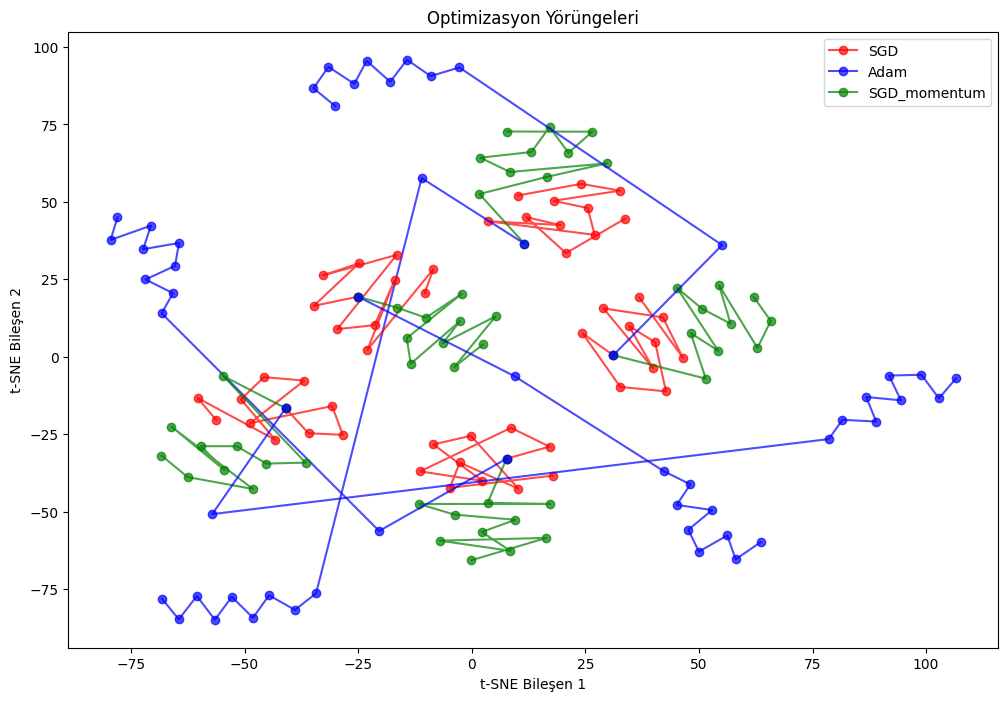

In [50]:
# 8. Yörüngelerin Görselleştirilmesi

# Renkleri belirle
colors = {'SGD': 'r', 'SGD_momentum': 'g', 'Adam': 'b'}

plt.figure(figsize=(12, 8))

start_idx = 0
for i, (opt_name, traj_len) in enumerate(zip(labels, trajectory_lengths)):
    end_idx = start_idx + traj_len
    x = tsne_results[start_idx:end_idx, 0]
    y = tsne_results[start_idx:end_idx, 1]
    # Her yörüngeyi çiz
    plt.plot(x, y, color=colors[opt_name],marker='o', label=opt_name if i % 5 == 0 else "", alpha=0.7)
    start_idx = end_idx

# Legend'da sadece algoritmaları göstermek için benzersiz etiketleri alalım
handles, labels_unique = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_unique, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Optimizasyon Yörüngeleri')
plt.xlabel('t-SNE Bileşen 1')
plt.ylabel('t-SNE Bileşen 2')
plt.show()

### Epoch vs Loss

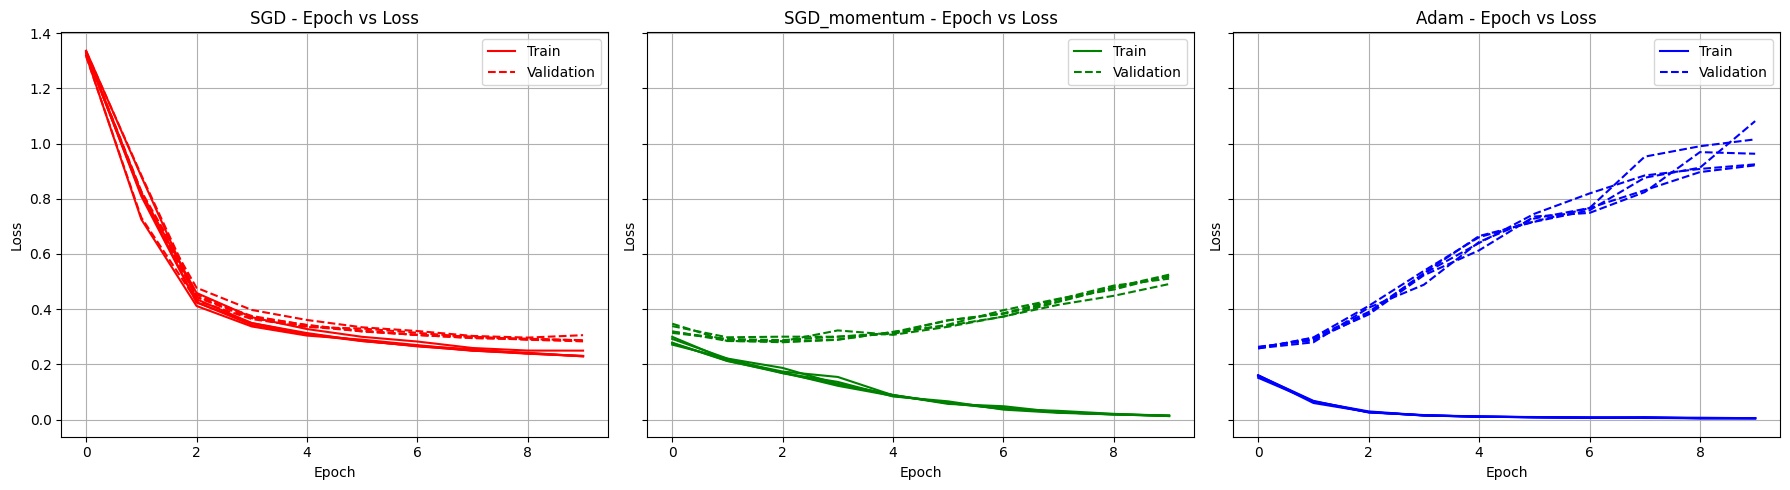

In [51]:
# Epoch vs Loss
# Optimizasyon algoritmalarının isimlerini alıyoruz
optimizer_names = list(optimizer_configs.keys())

# 3 tane alt grafik
num_algorithms = len(optimizer_names)

# Alt grafiklerin boyutlarını ayarlıyoruz
fig, axes = plt.subplots(nrows=1, ncols=num_algorithms, figsize=(6*num_algorithms, 5), sharey=True)

# Eğer tek bir grafik varsa, axes'i liste haline getirelim
if num_algorithms == 1:
    axes = [axes]

for idx, opt_name in enumerate(optimizer_names):
    ax = axes[idx]
    # Her algoritma için tüm başlangıç noktalarındaki eğitim geçmişini çizeceğiz
    for history in history_records[opt_name]:
        # Eğitim kaybı (Train Loss)
        ax.plot(history['loss'], linestyle='-', color=colors[opt_name],
                label='Train' if history == history_records[opt_name][0] else "")
        # Doğrulama kaybı (Validation Loss)
        ax.plot(history['val_loss'], linestyle='--', color=colors[opt_name],
                label='Validation' if history == history_records[opt_name][0] else "")

    ax.set_title(f'{opt_name} - Epoch vs Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


### Epoch vs Accuracy

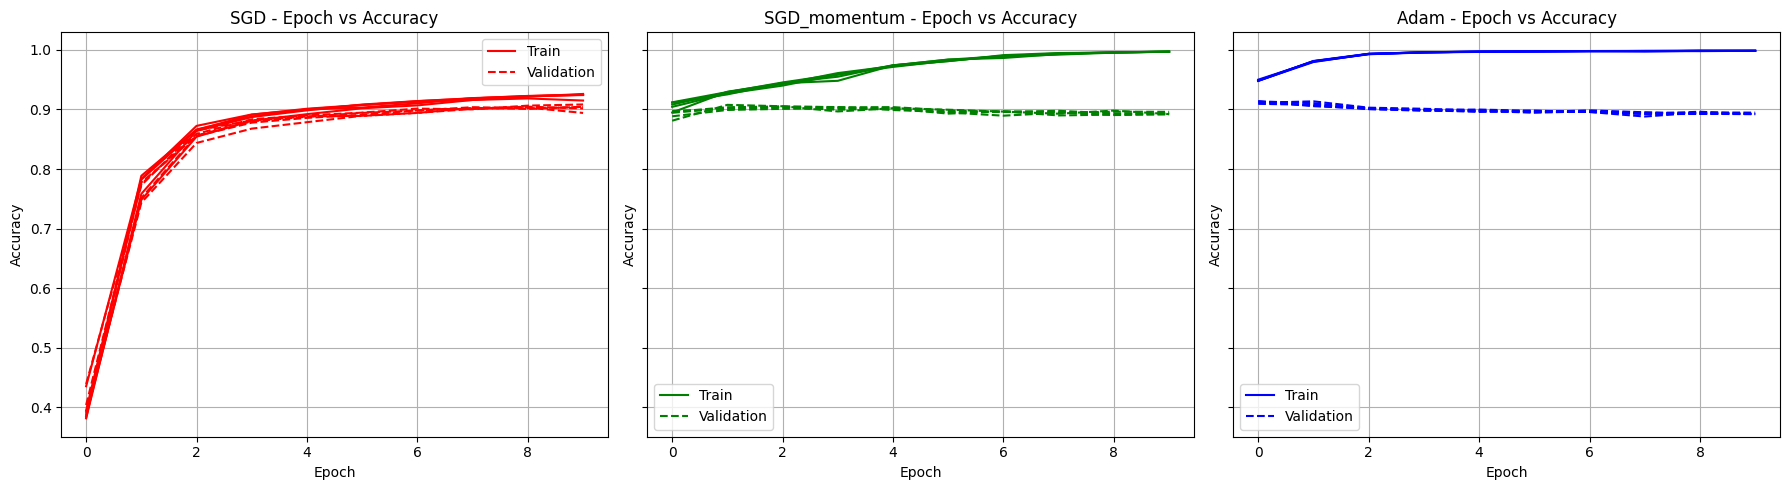

In [52]:
# Epoch vs Accuracy
# Alt grafiklerin boyutlarını ayarlıyoruz
fig, axes = plt.subplots(nrows=1, ncols=num_algorithms, figsize=(6*num_algorithms, 5), sharey=True)

# Eğer tek bir grafik varsa, axes'i liste haline getirelim
if num_algorithms == 1:
    axes = [axes]

for idx, opt_name in enumerate(optimizer_names):
    ax = axes[idx]
    # Her algoritma için tüm başlangıç noktalarındaki eğitim geçmişini çizeceğiz
    for history in history_records[opt_name]:
        # Eğitim doğruluğu (Train Accuracy)
        ax.plot(history['accuracy'], linestyle='-', color=colors[opt_name],
                label='Train' if history == history_records[opt_name][0] else "")
        # Doğrulama doğruluğu (Validation Accuracy)
        ax.plot(history['val_accuracy'], linestyle='--', color=colors[opt_name],
                label='Validation' if history == history_records[opt_name][0] else "")

    ax.set_title(f'{opt_name} - Epoch vs Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Time vs Loss

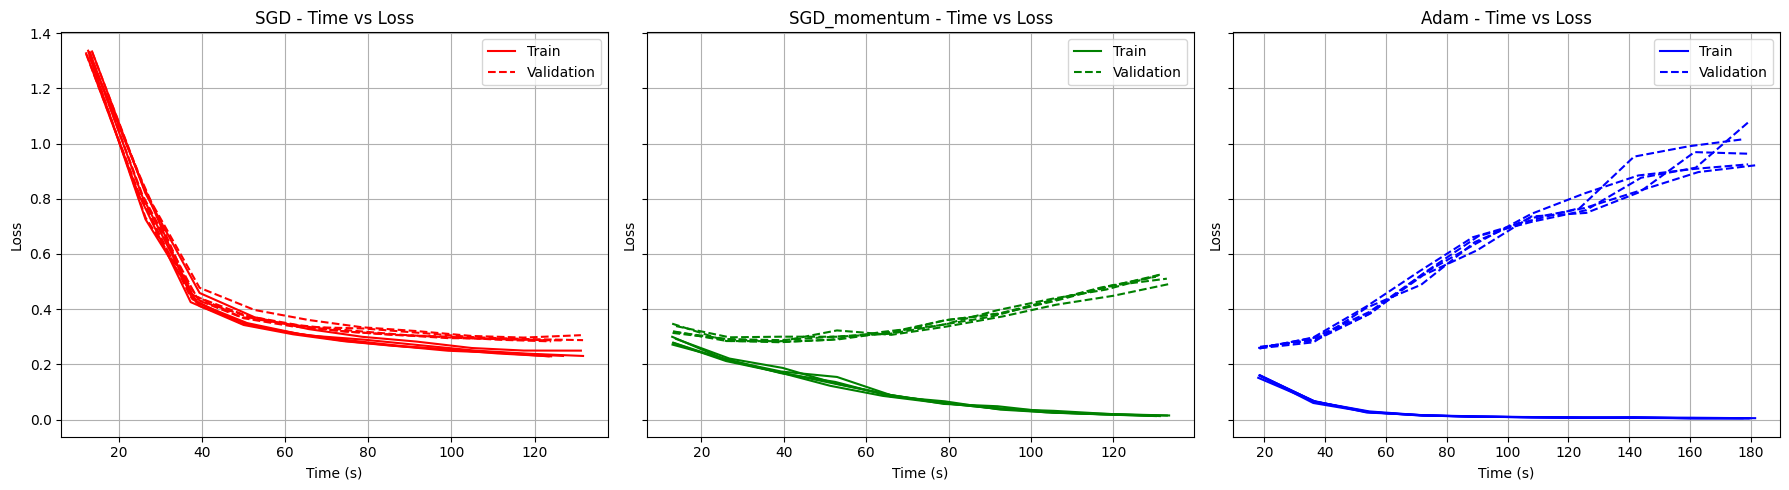

In [53]:
# Time vs Loss
# Alt grafiklerin boyutlarını ayarlıyoruz
fig, axes = plt.subplots(nrows=1, ncols=num_algorithms, figsize=(6*num_algorithms, 5), sharey=True)

# Eğer tek bir grafik varsa, axes'i liste haline getirelim
if num_algorithms == 1:
    axes = [axes]

for idx, opt_name in enumerate(optimizer_names):
    ax = axes[idx]
    # Her algoritma için tüm başlangıç noktalarındaki eğitim geçmişini çizeceğiz
    for idx_hist, (history, times) in enumerate(zip(history_records[opt_name], time_records[opt_name])):
        cumulative_times = np.cumsum(times)
        # Eğitim kaybı (Train Loss)
        ax.plot(cumulative_times, history['loss'], linestyle='-', color=colors[opt_name],
                label='Train' if idx_hist == 0 else "")
        # Doğrulama kaybı (Validation Loss)
        ax.plot(cumulative_times, history['val_loss'], linestyle='--', color=colors[opt_name],
                label='Validation' if idx_hist == 0 else "")

    ax.set_title(f'{opt_name} - Time vs Loss')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Time vs Loss (All)

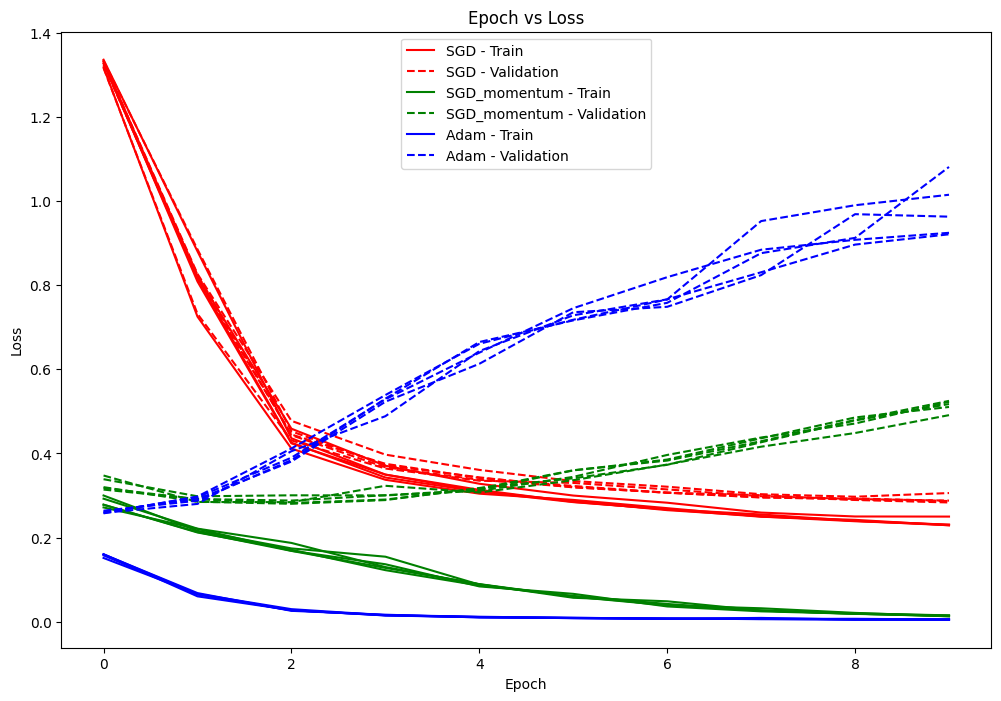

In [54]:
#### Epoch vs Loss Grafiği (Tümü)

plt.figure(figsize=(12, 8))

for opt_name in optimizer_configs.keys():
    for history in history_records[opt_name]:
        # Eğitim kaybı (Train Loss)
        plt.plot(history['loss'], linestyle='-', color=colors[opt_name],
                 label=f"{opt_name} - Train" if history == history_records[opt_name][0] else "")
        # Doğrulama kaybı (Validation Loss)
        plt.plot(history['val_loss'], linestyle='--', color=colors[opt_name],
                 label=f"{opt_name} - Validation" if history == history_records[opt_name][0] else "")

plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Time vs Loss (All)

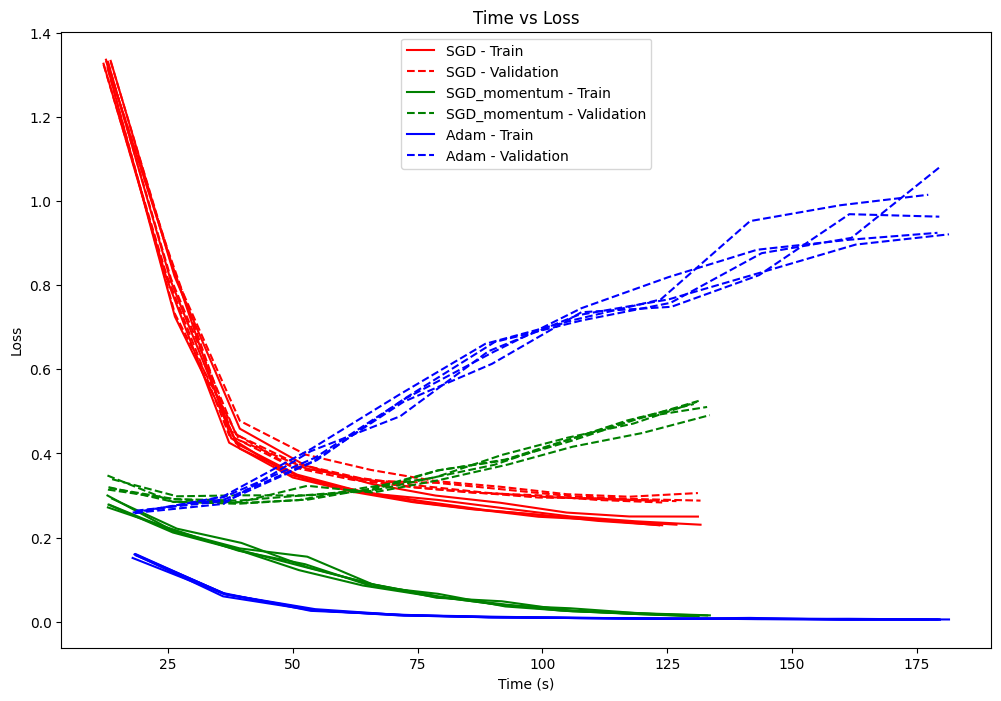

In [55]:
#### Time vs Loss Grafiği (TÜMÜ)

plt.figure(figsize=(12, 8))

for opt_name in optimizer_configs.keys():
    for idx, (history, times) in enumerate(zip(history_records[opt_name], time_records[opt_name])):
        cumulative_times = np.cumsum(times)
        # Eğitim kaybı (Train Loss)
        plt.plot(cumulative_times, history['loss'], linestyle='-', color=colors[opt_name],
                 label=f"{opt_name} - Train" if idx == 0 else "")
        # Doğrulama kaybı (Validation Loss)
        plt.plot(cumulative_times, history['val_loss'], linestyle='--', color=colors[opt_name],
                 label=f"{opt_name} - Validation" if idx == 0 else "")

plt.title('Time vs Loss')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.legend()
plt.show()